# Gamut Mapping - Ramblings 02

In [11]:
from __future__ import division, unicode_literals

import colour
import matplotlib.pyplot as plt
import numpy as np
import os
import scipy.interpolate
import scipy.optimize
from functools import reduce

COLOUR_STYLE = colour.plotting.colour_style()
COLOUR_STYLE.update({
    'figure.figsize': (10.24, 10.24),
    'legend.framealpha':
    colour.plotting.COLOUR_STYLE_CONSTANTS.opacity.low
})

plt.style.use(COLOUR_STYLE)

plt.style.use('dark_background')

colour.utilities.describe_environment()

colour.utilities.filter_warnings(*[True] * 4);

*                                                                             *
*   Interpreter :                                                             *
*       python : 3.7.6 (default, Dec 30 2019, 19:38:26)                       *
*                [Clang 11.0.0 (clang-1100.0.33.16)]                          *
*                                                                             *
*   colour-science.org :                                                      *
*       colour : v0.3.15-141-g3bebd7e9                                        *
*                                                                             *
*   Runtime :                                                                 *
*       imageio : 2.8.0                                                       *
*       matplotlib : 3.0.3                                                    *
*       numpy : 1.18.4                                                        *
*       scipy : 1.4.1                   

## Colour Wheel Generation

In [2]:
def colour_wheel(samples=1024, clip_circle=True, method='Colour'):
    xx, yy = np.meshgrid(
        np.linspace(-1, 1, samples), np.linspace(-1, 1, samples))

    S = np.sqrt(xx ** 2 + yy ** 2)    
    H = (np.arctan2(xx, yy) + np.pi) / (np.pi * 2)

    HSV = colour.utilities.tstack([H, S, np.ones(H.shape)])
    RGB = colour.HSV_to_RGB(HSV)

    if clip_circle == True:
        RGB[S > 1] = 0
        A = np.where(S > 1, 0, 1)
    else:
        A = np.ones(S.shape)

    if method.lower()== 'matplotlib':
        RGB = colour.utilities.orient(RGB, '90 CW')
    elif method.lower()== 'nuke':
        RGB = colour.utilities.orient(RGB, 'Flip')
        RGB = colour.utilities.orient(RGB, '90 CW')

    R, G, B = colour.utilities.tsplit(RGB)
    
    return colour.utilities.tstack([R, G, B, A])

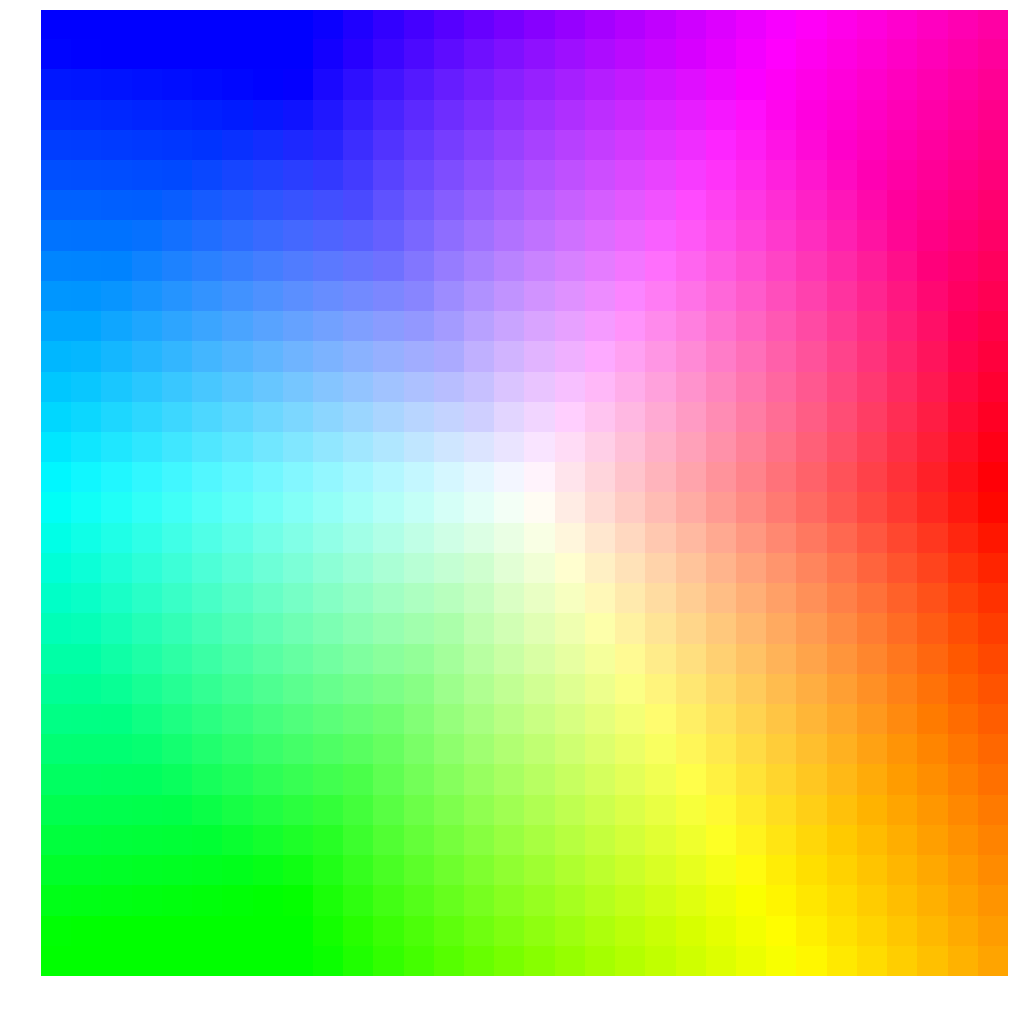

In [12]:
COLOUR_WHEEL = colour_wheel(samples=32, clip_circle=False, method='Nuke');

colour.plotting.plot_image(COLOUR_WHEEL);

## Compression Function

In [7]:
def tanh_compression_function(x, a=0.8, b=1 - 0.8):
    x = colour.utilities.as_float_array(x)

    return np.where(x > a, (a + b * np.tanh((x - a) / b)), x)

In [8]:
SAMPLES = np.linspace(0, 1, 360)


def medicina_HSV_control(H_y, H_x=SAMPLES, RGB=COLOUR_WHEEL[..., 0:3], S_c=0, C_f=tanh_compression_function):
    H, S, V = colour.utilities.tsplit(colour.RGB_to_HSV(RGB))

    interpolator = scipy.interpolate.interp1d(H_x, H_y)

    HSV = colour.utilities.tstack(
        [interpolator(H) % 1, C_f(S, S_c, 1 - S_c), V])

    return colour.HSV_to_RGB(HSV)


def medicina_RGB_saturation(RGB=COLOUR_WHEEL[..., 0:3], C_t=1, C_f=tanh_compression_function):
    C_t = 1 - C_t

    L = np.max(RGB, axis=-1)[..., np.newaxis]

    D = np.abs(RGB - L) / L

    D_c = C_f(D, C_t, 1 - C_t)

    RGB_c = L - D_c * L

    return RGB_c

RGB_S = medicina_RGB_saturation()

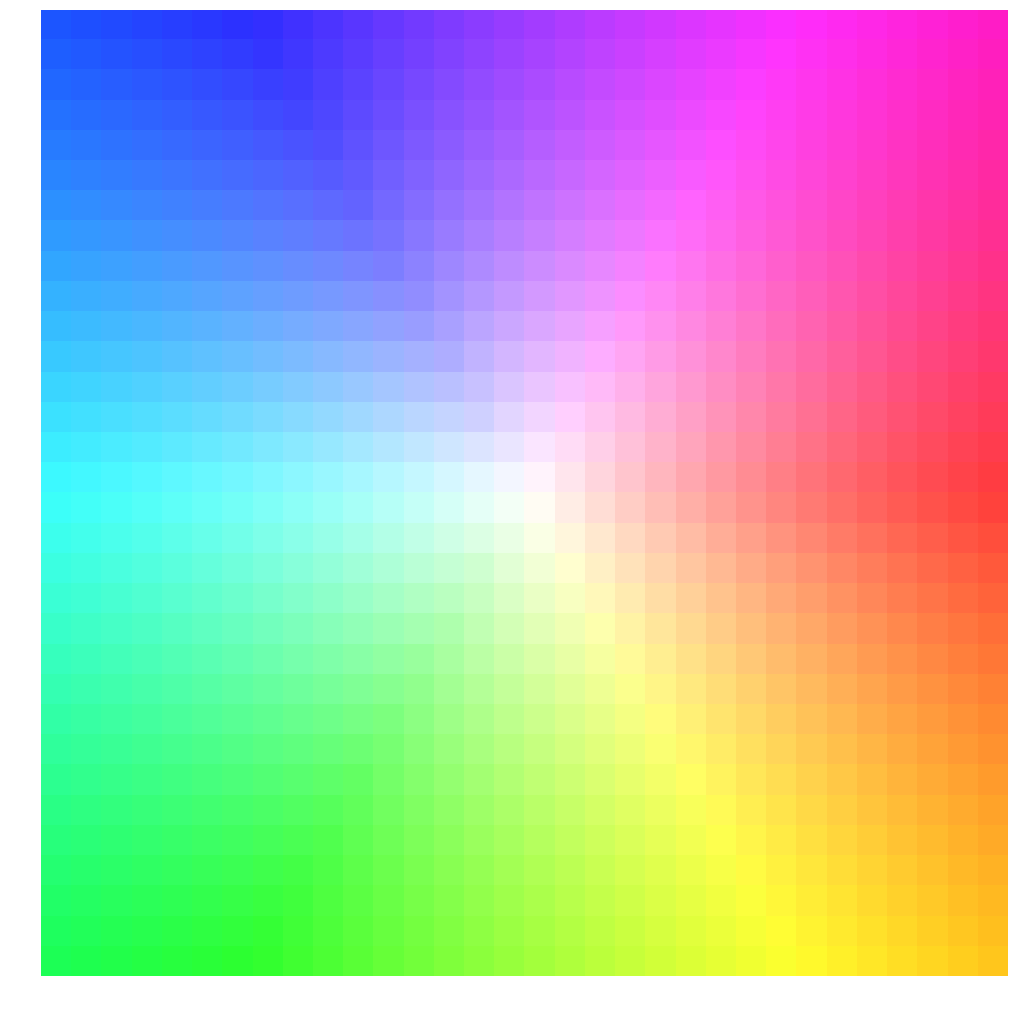

In [18]:
colour.plotting.plot_image(medicina_HSV_control(SAMPLES));

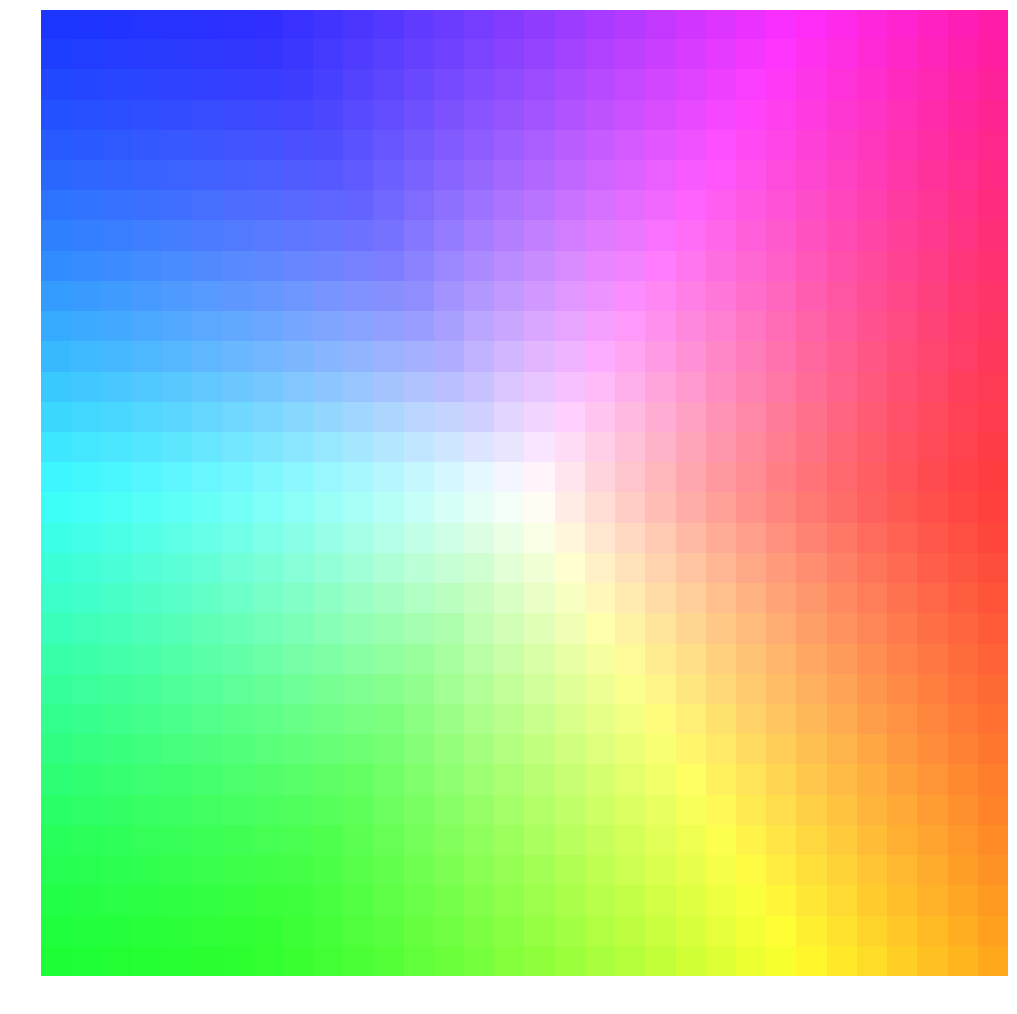

In [22]:
colour.plotting.plot_image(RGB_S);

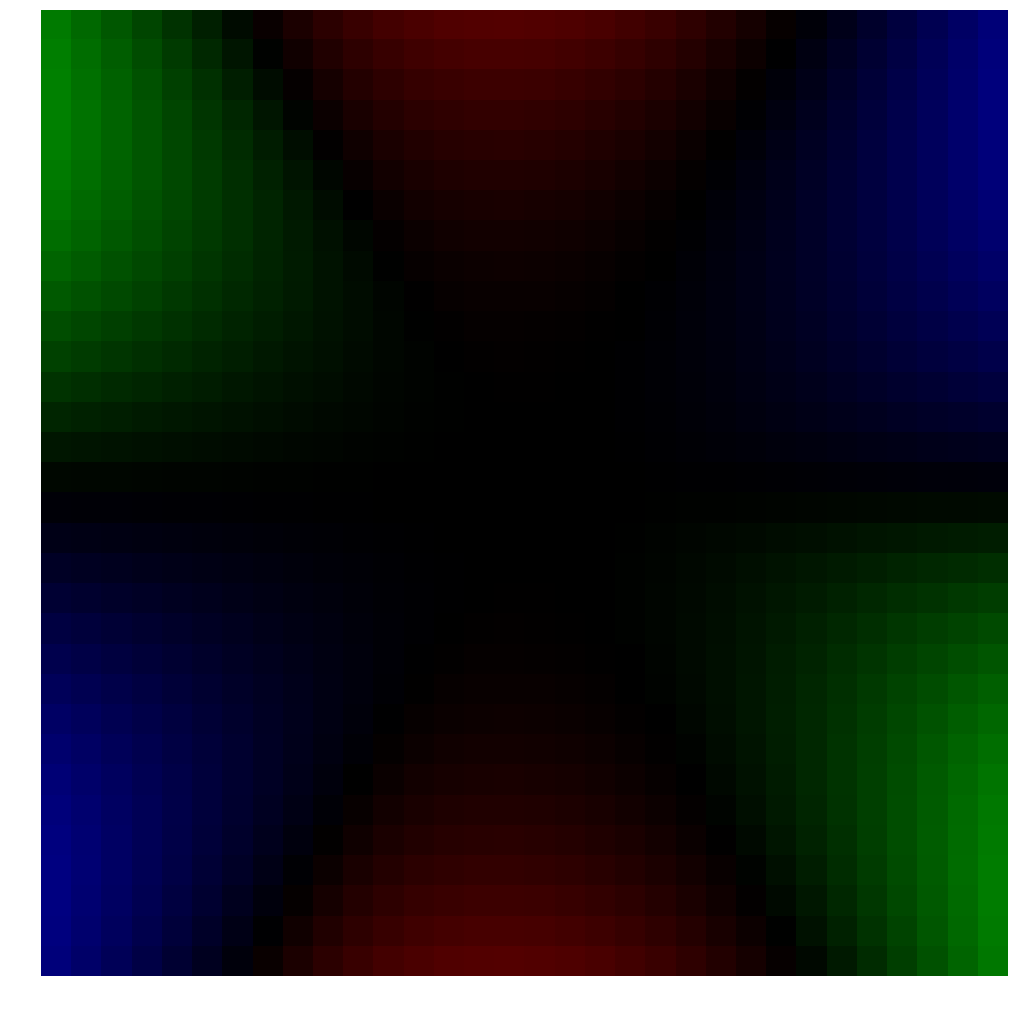

(<Figure size 1024x1024 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x11fd5dcd0>)

In [16]:
colour.plotting.plot_image(np.abs(medicina_HSV_control(SAMPLES) - RGB_S) * 4);

In [8]:
def objective_function(H_y):
    return np.sum(np.abs(medicina_HSV_control(H_y) - RGB_S))


I = 1
def callback(*args):
    global I
    print(I, args[0][:10])
    I += 1

    
O = scipy.optimize.minimize(objective_function, SAMPLES, callback=callback)

1 [ 0.          0.00205682 -0.009496   -0.0016407   0.00711744  0.00938597
  0.00701687  0.01312729  0.01706576  0.01758035]
2 [  0.00000000e+00   2.18177626e-03  -6.91230599e-03   7.36301312e-05
   7.80758641e-03   1.01647625e-02   8.67957900e-03   1.42198468e-02
   1.79606081e-02   1.46817934e-02]
3 [ 0.          0.00224626 -0.00557894  0.00095834  0.00816375  0.00900449
  0.00789742  0.01321665  0.01733001  0.01603582]
4 [ 0.          0.00227622 -0.00495942  0.0013694   0.00832923  0.00878948
  0.00787428  0.01307562  0.01726364  0.01576394]
5 [ 0.          0.00230196 -0.00442723  0.00172252  0.00847139  0.00853153
  0.0077775   0.01288101  0.0171554   0.01472272]
6 [ 0.          0.00231231 -0.00421337  0.00186442  0.00852851  0.00843752
  0.00774873  0.01281247  0.01711865  0.01473433]
7 [ 0.          0.0023225  -0.00400269  0.00200421  0.00858479  0.00834114
  0.00771644  0.01274118  0.01707982  0.01474572]
8 [ 0.          0.00233257 -0.00379434  0.00214245  0.00864044  0.00823954

In [9]:
O

      fun: 9.40509064097212
 hess_inv: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   9.09870758e-05,  -5.10678983e-06, ...,
          2.38914220e-07,  -4.17209033e-06,   0.00000000e+00],
       [  0.00000000e+00,  -5.10678983e-06,   7.70248941e-07, ...,
          2.62740539e-08,  -2.96803256e-07,   0.00000000e+00],
       ..., 
       [  0.00000000e+00,   2.38914220e-07,   2.62740539e-08, ...,
          8.75103687e-07,  -5.59684206e-06,   0.00000000e+00],
       [  0.00000000e+00,  -4.17209033e-06,  -2.96803256e-07, ...,
         -5.59684206e-06,   7.37866054e-05,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   1.00000000e+00]])
      jac: array([ 0.        , -0.5855732 ,  0.31238854,  1.93357384, -0.34951472,
        0.11736369,  1.17553425, -2.98736322,  3.37146676, -0.07131171,
       -3.40

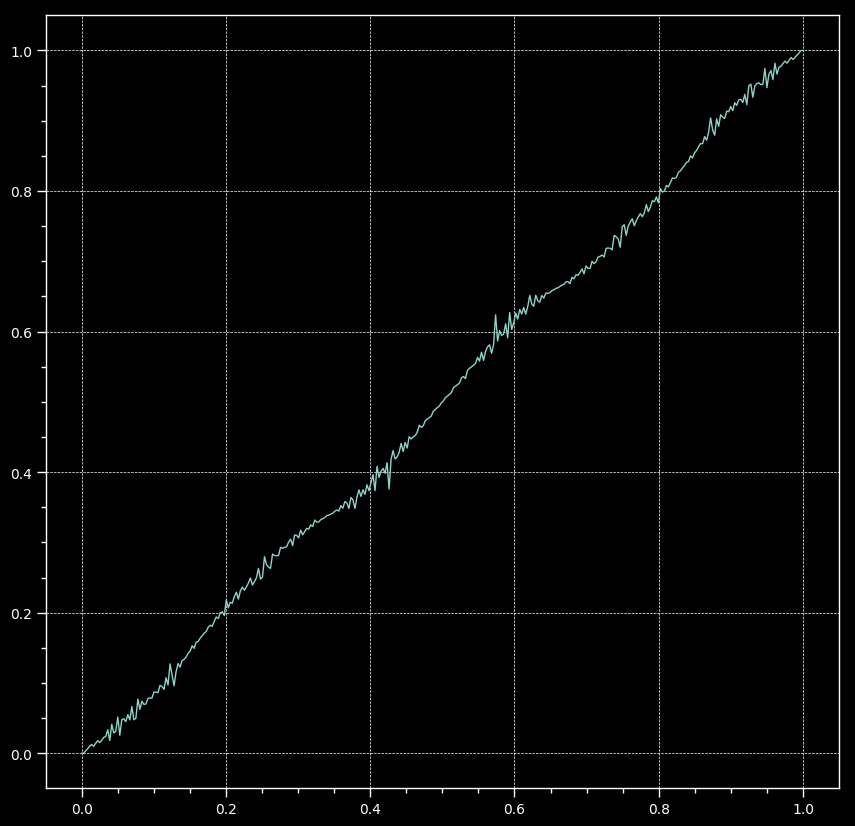

In [24]:
plt.plot(SAMPLES, O.x)

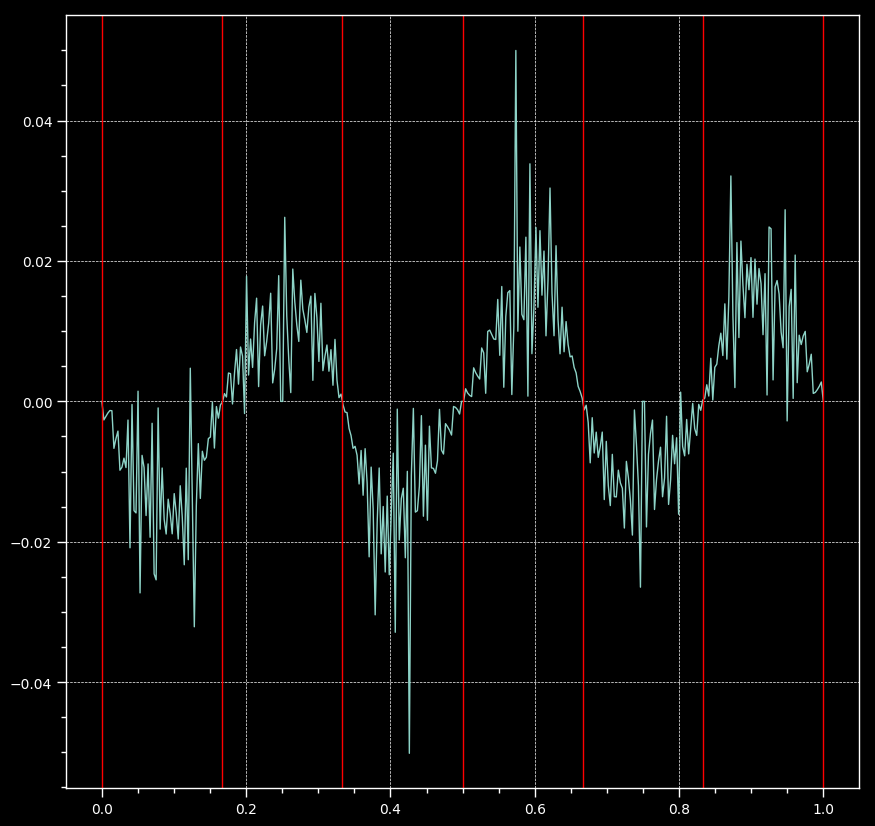

In [32]:
plt.plot(SAMPLES, O.x - SAMPLES)
for i in np.arange(0, 360 + 60, 60) / 360:
    plt.axvline(i, c='r')

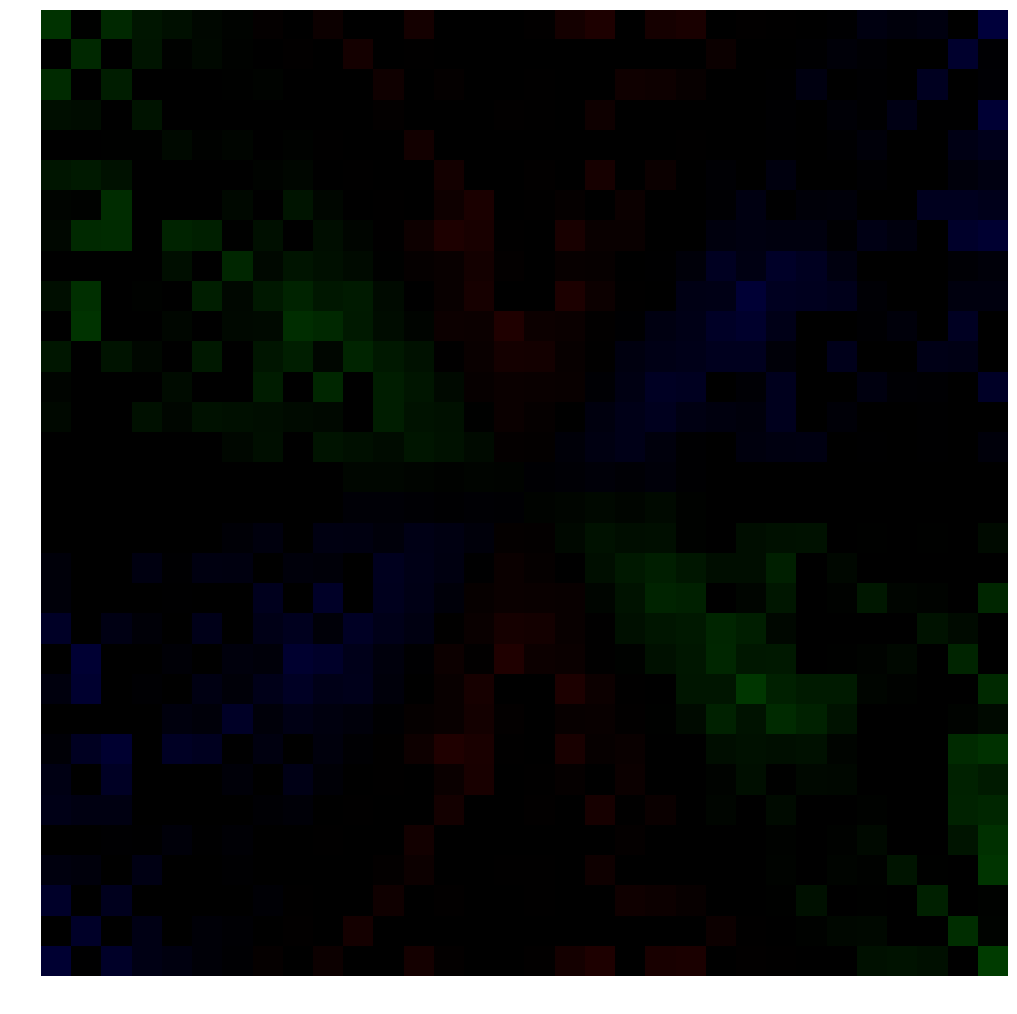

In [17]:
colour.plotting.plot_image(np.abs(medicina_HSV_control(O.x) - RGB_S) * 4);